# Installing the NAG Library and running this notebook
To run this notebook, you will need to install the NAG Library for Python (Mark 26.1 or newer) and a license key. You can find the software and have a license key (trials are available) from our website here: [Getting Started with NAG Library](https://www.nag.com/content/getting-started-nag-library?lang=py&os=linux)

# Dynamic pricing in revenue management using the NAG Library

Disciplined pricing tactics are the key in revenue management in order to sell the right product to the right customer at the right time. Commonly implemented pricing strategies include cost-based pricing, market-based pricing, dynamic pricing, price skimming, etc. It depends on various factors such as the nature of the business and the target market to decide the most suitable strategy. During the pricing process, optimization plays an important role in demand forecasting and revenue maximization. In this notebook, we show how to use the NAG Optimization Modelling Suite (delivered with the NAG Library) by implementing a dynamic pricing strategy which achieves increased revenue over random pricing and price matching strategy. 

The models considered here do not assume that the demand as a function of price is known in advance, but rather assume parametric family of demand functions that are learned over time. During the learning process, the Linear Programming (LP) solver [handle_solve_lp_ipm](https://www.nag.com/numeric/py/nagdoc_latest/naginterfaces.library.opt.handle_solve_lp_ipm.html) in the NAG Library is used to build and solve the models. Included in the NAG Optimization Modelling Suite, the LP solver is well suited for this task, due to the great flexibility provided on building and modifying the problem.

In [1]:
# Import the optimization module from the NAG Library for Python, and necessary packages
from naginterfaces.library import opt
import numpy as np

## Introduction
We focus on a market with two companies competing for a single product in a dynamic environment, in which each company not only estimates its own demand, but also needs to predicts its competitor's demand and pricing strategy. For simplicity, we assume an uncapacitated setting, i.e., there is no limitation on the capacity that each company needs to allocate.

Linear function is one of the most commonly used demand functions in theory and practice. Assuming the true demand parameters are time dependent, the demand function of company $k=1,2$ can be defined as
$$d_{k,t} = \beta_{k,t}^0 + \beta_{k,t}^1p_{1,t} + \beta_{k,t}^2p_{2,t} + \epsilon_{k,t},$$
where $p_{1,t}$ and $p_{2,t}$ are the prices of company 1 and 2 at time t, respectively. This model assumes that demand for each company $k = 1, 2$ depends on its own as well as its competitors current period prices $p_{1,t}$ and $p_{2,t}$. $\beta_{k,t}^i$, $i = 0, 1, 2$ are unknown parameters and $\epsilon_{k,t} \sim N(0, \sigma_{k,t}^2)$ is a random noise.

In the beginning of each period t, company 1 knows the realizations of its own demand $d_{1,s}$, its own prices $p_{1,s}$ , as well as its competitor's prices $p_{2,s}$, for $s = 1, \ldots, t-1$. It does not directly observe its competitor's demand. The objectives are to estimate its own demand, its competitor's reaction and finally, set its own prices dynamically to maximize the total expected revenue.

In this exercise we define the true models of demand are as follows.
$$
d_{1,t} = 50 -0.05p_{1,t} + 0.03p_{2,t} + \epsilon_{1,t},
$$
$$
d_{2,t} = 50 +0.02p_{1,t} - 0.06p_{2,t} + \epsilon_{2,t},
$$
where the $\epsilon_{1,t},~\epsilon_{2,t}\sim N(0, 16)$.

In [2]:
def demand_true(company, p1, p2):
    if company == 1:
        return 50 - 0.05*p1 + 0.03*p2 + np.random.normal(scale=4.0)
    elif company == 2:
        return 50 + 0.02*p1 - 0.06*p2 + np.random.normal(scale=4.0)

## Demand estimation
The following optimization problem is solved in order to estimate the demand of company 1.
$$
\min_{\hat{\beta}_1}~~\sum_{\tau=1}^{t-1} |d_{1,\tau} - (\hat{\beta}_{1,\tau}^0+\hat{\beta}_{1,\tau}^1p_{1,\tau}+\hat{\beta}_{1,\tau}^2p_{2,\tau})|,
$$
$$
s.t. ~~ |\hat{\beta}_{1,\tau}^i - \hat{\beta}_{1,\tau+1}^i| \leq \delta_1(i), ~ i = 0, 1, 2, ~\tau = 1,2,\ldots, t-2,
$$
$$
~~ \hat{\beta}_{1,\tau}^0\geq0,~\hat{\beta}_{1,\tau}^1 \leq0,~\hat{\beta}_{1,\tau}^2\geq0,~\tau = 1,2,\ldots, t-1,
$$
where $\hat{\beta}_1$ is defined as an array of all the variables. Note the first set of constraints is to control the changes on the parameters.

Once the optimal solution $(\hat{\beta}_{1, \tau}^i)^*$, $i = 0, 1, 2$, $\tau = 1, \ldots, t-1$ is obtained, the new estimate is given by an average of the estimates of the N previous periods
$$
\hat{\beta}_{1, t}^i = \frac{1}{N}\sum_{l=t-N}^{t-1}(\hat{\beta}_{1, l}^i)^*,~ i = 0, 1, 2.
$$

By introducing auxiliary variables $y_\tau$, $\tau = 1, \ldots, t-1$, the above optimization problem can be reformulated as the following linear programming problem.
$$
\min_{({\hat{\beta}_1}, y)}~~\sum_{\tau=1}^{t-1} y_{\tau},
$$
$$
s.t. ~~-y_\tau \leq d_{1,\tau} - (\hat{\beta}_{1,\tau}^0+\hat{\beta}_{1,\tau}^1p_{1,\tau}+\hat{\beta}_{1,\tau}^2p_{2,\tau}) \leq y_\tau,~\tau = 1,2,\ldots, t-1,
$$
$$
~~ -\delta_1(i)\leq\hat{\beta}_{1,\tau}^i - \hat{\beta}_{1,\tau+1}^i \leq \delta_1(i), ~ i = 0, 1, 2, ~\tau = 1,2,\ldots, t-2,
$$
$$
~~ \hat{\beta}_{1,\tau}^0\geq0,~\hat{\beta}_{1,\tau}^1 \leq0,~\hat{\beta}_{1,\tau}^2\geq0,~\tau = 1,2,\ldots, t-1.
$$
Here we assume the prices for both companies range in the interval $[100, 900]$, the time horizon is $T = 150$. And the initial prices are $p_{1,1} = p_{2,1} = 500$.

In [3]:
# Fix the random seed
np.random.seed(5)

# Big bound to inform the solver on infinity
bigbnd = 1.e20

# Optimization model parameters
delta = np.array([30, 0.05, 0.05])
T = 150

# Initial prices
p1 = [500]
p2 = [500]

# Array to store realised true demand of company 1
# For final revenue calculation
demand_1_true = []

Now we can go ahead and initialize an empty model. 

In [4]:
# Initialize an empty problem
nvar = 0
handle = opt.handle_init(nvar)

Observe that for $t = 2, \ldots, T$, the model is getting bigger with more variables and constraints added. At each time period t, a new set of 4 new variables $[\hat{\beta}_{1,t-1}^0, \hat{\beta}_{1,t-1}^1, \hat{\beta}_{1,t-1}^2, y_{t-1}]$ is added, as well as the contraints involving them.

## Pricing optimization
Company 1 can set its prices by maximizing its current period t revenues. That is to solve the following unconstrained quadratic programming problem
$$
\max_{p_1,t}~~ p_{1,t} (\hat{\beta}_{1,t}^0+\hat{\beta}_{1,t}^1p_{1,t}+\hat{\beta}_{1,t}^2\hat{p}_{2,t}),
$$
which has the optimal solution of the form
$$
p_{1,t}^* = \frac{\hat{\beta}_{1,t}^0+\hat{\beta}_{1,t}^2\hat{p}_{2,t}}{-2\hat{\beta}_{1,t}^1}.
$$
Note we've still got to estimate the price of company 2 at time t in order to use the pricing strategy above. For simplicity, we use an average of the prices company 2 sets in the N previous periods,
$$
\hat{p}_{2,t} = \frac{1}{N}\sum_{l=t-N}^{t-1} p_{2, l}.
$$

In [5]:
# Pricing of company 2, estimated by company 1
p2_est = lambda p2 : sum(p2)/len(p2)

# Optimal pricing for company 1
def optimize_p1(t, p1, beta_t, p2_est):
    
    # When t = 2, the data is insufficient
    # the linear programming problem has multiple optimal solutions
    # Heuristic to make sure price 1 is well-defined
    if (beta_t[1] == 0):
        p1_opt = p1[t-2]
    else:
        p1_opt = (beta_t[0] + beta_t[2]*p2_est)/(-2.0*beta_t[1])

    # Project price if outside of interval
    p1_opt = max(100, min(900, p1_opt))

    return p1_opt

With pricing functions prepared and empty model initialized, we are finally ready to build up the models and solve along the line for different time periods. With the NAG Optimization Modelling Suite, adding variables and constraints is very straight forward, which makes it very easy to learn the demand function coefficients with new data coming in after each time period, as demonstrated with the following code.

In [6]:
for t in range(2, T+1):
    
    # In each demand estimation, 4 new variables  will be added to the model
    # [beta_0, beta_1, beta_2, y]
    opt.handle_add_vars(handle, 4)
    
    # Only the auxiliary variable y will oppear in the objective
    # Set y coefficient in the linear objective
    opt.handle_set_linobj_coeff(handle, nvar+4, 1.0)

    # Set bound constraints for beta
    # Beta_0
    opt.handle_set_bound(handle, 'X', nvar+1, 0.0, bigbnd)
    # Beta_1
    opt.handle_set_bound(handle, 'X', nvar+2, -bigbnd, 0.0)
    # Beta_2
    opt.handle_set_bound(handle, 'X', nvar+3, 0.0, bigbnd)

    # Get realised demand for the previous period for company 1
    d1_true = demand_true(1, p1[t-2], p2[t-2])
    # Save true demand for previous period
    demand_1_true.append(d1_true)

    # Add first set of contraints
    opt.handle_set_linconstr(handle, -bigbnd, d1_true, [1, 1, 1, 1], 
                             [nvar+1, nvar+2, nvar+3, nvar+4], [1, p1[t-2], p2[t-2], -1.0])
    opt.handle_set_linconstr(handle, d1_true, bigbnd, [1, 1, 1, 1], 
                             [nvar+1, nvar+2, nvar+3, nvar+4], [1, p1[t-2], p2[t-2], 1.0])

    # Add second set of constraints to control beta to vary slowly
    if (t >= 3):
        opt.handle_set_linconstr(handle, -delta, delta, [1, 1, 2, 2, 3, 3],
                                 [nvar+1, nvar+1-4, nvar+2, nvar+2-4, nvar+3, nvar+3-4],
                                 [1.0, -1.0, 1.0, -1.0, 1.0, -1.0])

    # Call the linear programming solver
    # Choose the algorithm that will be used
    opt.handle_opt_set(handle, 'LPIPM Algorithm = SD')
    # Turn off printing of the log
    opt.handle_opt_set(handle, 'Print File = -1')
    sol = opt.handle_solve_lp_ipm(handle)

    # Calculate beta for period t based on the estimates for previous periods
    beta_t = [0.0, 0.0, 0.0]
    for i in range(0, nvar+4, 4):
        beta_t+=sol.x[i:i+3]
    beta_t /= t-1

    # Get optimal pricing for company 1 at time t
    p1_opt = optimize_p1(t, p1, beta_t, p2_est(p2))

    # Save optimal pricing at time t
    p1.append(p1_opt)

    # Assuming company 2 is implementing price match
    p2.append(p1[t-2])

    # Update number of total variables in the model
    nvar += 4

# Solving process finished, deallocate problem model
opt.handle_free(handle)

## Results
After the pricing stage, we are ready to calculate the actual revenue for each strategy. For comparison, we implemented two other strategies: random and price matching. The random prices are generated under the uniform distribution from the price range. The price matching policy sets the price for the current period the company 1 set in the previous period.

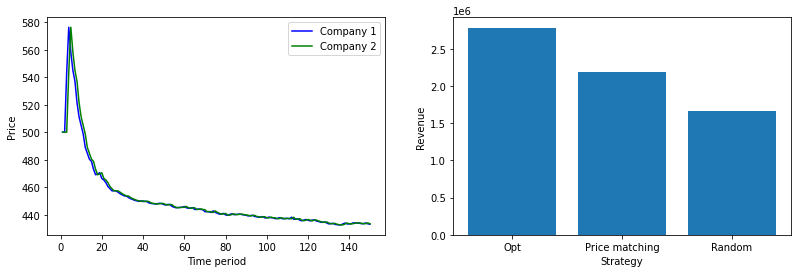

In [7]:
# Calculate revenue based on the pricing strategies
revenue_opt = 0.0
revenue_price_match= 0.0
revenue_random = 0.0

# Get the true demand for period T for company 1
# since it was not used/generated during the pricing stage
demand_1_true.append(demand_true(1, p1[T-1], p2[T-1]))

# Generate prices based on uniform distribution for comparison
p3 = np.random.uniform(100, 900, T)

# Calculate revenues for each strategy
# revenue = price * demand
for i in range(T):
    revenue_opt += p1[i]*demand_1_true[i]
    revenue_price_match += p2[i]*demand_true(2, p1[i], p2[i])
    revenue_random += p3[i]*demand_true(2, p1[i], p3[i])

import matplotlib.pyplot as plt

fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.arange(1, T+1), p1, 'b', label='Company 1')
ax.plot(np.arange(1, T+1), p2, 'g', label='Company 2')
ax.set_xlabel('Time period')
ax.set_ylabel('Price')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
strategies = ['Opt', 'Price matching', 'Random']
ax.set_xlabel('Strategy')
ax.set_ylabel('Revenue')
ax.bar(strategies, [revenue_opt, revenue_price_match, revenue_random])

plt.show()

By the plot above on the price history over time, we can see the price of company 1, by employing the optimization learning approach, converges to a stable status as time goes. Company 2 is always one period behind as it uses price matching. From the figure on the right, for this single simulation, we can see using the optimization approach achieves much higher renenue than price matching. And random pricing is the worst in this scenario. 

In this notebook, we have shown how to use the NAG Optimization Modelling Suite for pricing strategies under complex market conditions and demand. The flexibility provided makes it very efficient to conduct simulations in search for the most suitable pricing strategies.

Learn more about the [NAG Library](https://www.nag.com/content/nag-library) and the [NAG Optimization Modelling Suite](https://www.nag.com/mathematical-optimization/)